### DNN 기반 다중분류 모델 구현 <hr>
- 데이터셋 : iris.csv
- 피쳐/속성 : 4개 Sepal_Length, Sepan_Width, Petal_ Length, Peatal_Width
- 타겟/라벨 : 1개 variety
- 학습방벙 : 지도학습 > 분류 > 다중 분류
- 알고리즘 : 인공신경망 (ANN) -> MLP(Multi Layer Percetron),  심층신경망(DNN)(은닉층 多)
- 프레임워크 : Pytorch
---

[1] 모듈 로딩 및 데이터 준비  <hr>

In [1]:
# 모듈로딩
# Model 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torchmetrics.classification import MulticlassF1Score
from torchinfo import summary

# - Data관련
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

In [2]:
# 활용 패키지 버전 체크 - 사용자 정의 함수로 구현할것!
print(f'Pytorch v.{torch.__version__}')
print(f'Pandas v.{pd.__version__}')

Pytorch v.2.4.1
Pandas v.2.0.3


In [3]:
## 데이터로딩
DATA_FILE='../../../수업/MachineLearning/data/iris.csv'

## CSV >> DataFrame
irisDF=pd.read_csv(DATA_FILE)

## 확인
irisDF.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [4]:
# 타겟 정수화
labels=dict(zip(irisDF['variety'].unique().tolist(),range(3)))
print(f'labels=> {labels}')
# 라벨인코딩<<
irisDF['variety']=irisDF['variety'].replace(labels)
irisDF.head()

labels=> {'Setosa': 0, 'Versicolor': 1, 'Virginica': 2}


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


[2] 모델 클래스 설계 및 정의 <hr>
- 클래스목적 : iris 데이터를 학습 및 추론 목적
- 클래스이름 : IrisBCFModel
- 부모클래스 : nn.Module
- 매개변수 : 층별 입출력 갯수 고정하므로 필요 없음
- 속성/필드 : featruesDF, targetDF, n_rows, n_features
- 기능/역할 <필수 >
    -  __ init __() : 모델 구조 설정 
    - forward() : 순방향 학습 <- 오버라이딩(overriding)
- 클래스구조
    - 입력층 : 입력 4개 / 출력 10개 (퍼셉트론/뉴런 10개 존재)
    - 은닉층 : 입력 10개 / 출력 5개 (퍼셉트론/뉴런 30개 존재) 
    - 출력층 : 입력 5개 / 출력 1개 (다중분류)
- 손실함수/ 활성화함수 
    - 클래스형태 => nn. 아래  
        - ex) nn.ReLu << __init__() 에 사용
    - 함수 형태 => torch.nn.functional 아래
        - ex) F.relu << def forward() 에 사용


In [5]:
class IrisMCFModel(nn.Module):

    # 모델 구조 구성 및 인스턴스 생성 메서드
    def __init__(self):
        super().__init__()

        self.in_layer=nn.Linear(4,10)
        self.hd_layer=nn.Linear(10,5)
        self.out_layer=nn.Linear(5,3)   # 다중분류

    # 순방향 학습 진행 메서드
    def forward(self,x):
        # - 입력층
        y=self.in_layer(x)        # f1_1w1_1+f1_2w1_2+f1_3w1_3+b << 이런식 10개
        y=F.relu(y)

        # - 은닉층 : 10개의 숫자값 (>=0)
        y=self.hd_layer(y)        # f2_1w2_1+f2_2w2_2+....f2_10w2_10 +b << 이런식 5개
        y=F.relu(y)

        # - 출력층 : 5개의 숫자값 (>=0) - 다중분류 : 손실함수 crossentroploss 가 내부에서 softmax진행
        return self.out_layer(y)        # f3_1w3_1+.....f3_30w3_30+b << 1 개



In [6]:
### [테스트] 모델 인스턴스 생성
model=IrisMCFModel()

print(model)

IrisMCFModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hd_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=3, bias=True)
)


In [7]:
### [테스트] 모델 확인
summary(model,input_size=(17,4))

Layer (type:depth-idx)                   Output Shape              Param #
IrisMCFModel                             [17, 3]                   --
├─Linear: 1-1                            [17, 10]                  50
├─Linear: 1-2                            [17, 5]                   55
├─Linear: 1-3                            [17, 3]                   18
Total params: 123
Trainable params: 123
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

[3] 데이터셋 클래스 설계 및 정의 <hr>
- 데이터셋 : iris.csv
- 피쳐개수 : 4개
- 타겟개수 : 1개
- 클래스이름 : IrisDataset
- 부모클래스 : utils.data.Dataset
- 속성필드 : featureDF, targetDF, n_rows, n_features
- 필수메서드 
    - __ init __(self) : 데이터셋 저장 및 전처리, 개발자가 필요한 속성 설정
    - __ len __(self) : 데이터의 개수 반환
    - __ getitem __(self,index) : 특정 인덱스의 피쳐와 타겟 반환

In [8]:
class IrisDataset(Dataset):

    def __init__(self,featureDF,targetDF):
        self.featureDF=featureDF
        self.targetDF=targetDF
        self.n_rows=featureDF.shape[0]      # 필수아님
        self.n_features=featureDF.shape[1]  # 필수아님


    def __len__(self):
        return self.n_rows
        
    def __getitem__(self, index):
        # 텐서화
        featureTS=torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS=torch.FloatTensor(self.targetDF.iloc[index].values)
        
        # 피쳐와 타겟 반환
        return featureTS, targetTS
    

In [9]:
## [테스트] 데이터셋 인스턴스 생성

featureDF=irisDF[irisDF.columns[:4]]        # 2D (150,3)
targetDF=irisDF[irisDF.columns[[4]]]        # 2D (150,1)

# - 커스템데이터셋 인스턴스 생성
irisDS=IrisDataset(featureDF,targetDF)

# 데이터 로드 인스턴스 생성
irisDL=DataLoader(irisDS)
for feature,target in irisDL:
    print(feature,target)
    break


tensor([[5.1000, 3.5000, 1.4000, 0.2000]]) tensor([[0.]])


[4] 학습 준비
- 학습횟수 : EPOCH <- 처음부터 끝까지 공부하는 횟수
- 배치크기 : BATCH_SIZE <- 한번에 학습할 데이터셋 양
- 위치지정 : DEVICE <- 텐서 저장 및 실행 위치 (GPU/CPU)
- 학습률(LR, learning Rate) : 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정 0.001~0.1

In [10]:
### 학습 진행 관련 설정 값 
EPOCH = 100
BATCH_SIZE= 10
DEVICE ='cuda' if torch.cuda.is_available() else 'cpu'
LR=0.001

- 인스턴스/객체 : 모델, 데이터셋, 최적화, 손실함수 (, 성능지표)

In [11]:
# 모델 인스턴스
model= IrisMCFModel()

# 데이터셋 인스턴스
# # 학습,검증,테스트 데이터 분리
X_train, X_test, y_train, y_test=train_test_split(featureDF,targetDF,random_state=1)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,random_state=1)
print(f' X_train : {X_train.shape}, X_val : {X_val.shape} , X_test : {X_test.shape}')
print(f' y_train : {y_train.shape}, y_val : {y_val.shape} , y_test : {y_test.shape}')



trainDS=IrisDataset(X_train,y_train)
valDS=IrisDataset(X_val,y_val)
testDS=IrisDataset(X_test,y_test)

# 데이터로더 인스턴스
trainDL=DataLoader(trainDS,batch_size=BATCH_SIZE)

 X_train : (84, 4), X_val : (28, 4) , X_test : (38, 4)
 y_train : (84, 1), y_val : (28, 1) , y_test : (38, 1)


- 최적화 , 손실함수 인스턴스 생성

In [12]:
# 최적화 인스턴스 => W,b 텐서 즉, model.parameters() 전달
optimizer=optim.Adam(model.parameters(),lr=LR)

# 손실함수 인스턴스 => 분류 => 다중분류 CrossEntropyLoss 
#                            예측값은 선형식 결과값값으로 전달 => sigmoid() AF처리후 전달
crossLoss=nn.CrossEntropyLoss()

[5] 학습진행

In [13]:
### models 폴더 아래 프로젝트 폴더 아래 모델파일 저장
import os

# 저장경로
SAVE_PATH='../models/iris/MCF/'
# 저장 파일명
SAVE_FILE=SAVE_PATH+'model_train_wbs.pth'

# 모델 구조 및 파라미터 모두 저장 파일명
SAVE_MODEL=SAVE_PATH+'model_all.pth'

# 경로상 폴더 존재 여부 체크

if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)  # 폴더/폴더/... 하위폴더까지 생성

In [14]:
## 학습의 효과 확인 손실값과 성능 평가값 저장 필요
LOSS_HISTORY,SCORE_HISTORY=[[],[]],[[],[]]

# 학습 모니터링/스케쥴링 설정
# => LOSS_HISTORY, SCORE_HISTORY활용
# 임계기준 : 10번 (내가설정)
BREAK_CNT= 0

# 학습 모드로 모델 설정
 
for epoch in range(EPOCH):
    model.train()  ## 학습모드 켜기! 에포크 단위로 학습과 검증 진행시 for문안에서 껐다 켯다 해야함! 

    # 배치 크기 만큼 데이터 로딩해서 학습 진행
    loss_total=0
    score_total=0
    for featureTS,targetTS in trainDL:

        # 학습 진행
        pre_y=model(featureTS)

        # 손실 계산 # nn.CrossEntropyLoss 요구사항 : 정답/타겟 0D or1D 타입은 long
        loss=crossLoss(pre_y,targetTS.reshape(-1).long())
        loss_total+=loss.item()

        # 성능평가 계산
        score=MulticlassF1Score(num_classes=3)(pre_y,targetTS.reshape(-1))
        score_total+=score.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval() # 검증모드 켜기!
    with torch.no_grad():
        # 검증데이터셋
        val_featureTS=torch.FloatTensor(valDS.featureDF.values)
        val_targetTS=torch.FloatTensor(valDS.targetDF.values)

        # 평가
        pre_val = model(val_featureTS)
        #손실
        val_loss=crossLoss(pre_val,val_targetTS.reshape(-1).long())
        # 성능평가
        val_score=MulticlassF1Score(num_classes=3)(pre_val,val_targetTS.reshape(-1))
    
    # 손실값과 성능 평가값 저장
    LOSS_HISTORY[0].append(loss_total/len(trainDL))
    SCORE_HISTORY[0].append(score_total/len(trainDL))

    LOSS_HISTORY[1].append(val_loss.item())
    SCORE_HISTORY[1].append(val_score.item())

    print(f'[{epoch}/{EPOCH}]')
    print(f'trainloss={loss_total/len(trainDL)} trainscore={score_total/len(trainDL)}')
    print(f'valloss={val_loss} trainscore={val_score}')

        # Score 기준
    if len(SCORE_HISTORY[0])>=2:
        if SCORE_HISTORY[1][-1] <= SCORE_HISTORY[1][-2]:
            BREAK_CNT+=1
    #loss나 score 둘중 하나만 사용
    
    # 성능이 좋은 학습 가중치 저장
    if len(SCORE_HISTORY[0])==1:
        # 첫번째라서 무조건 모델 저장
        torch.save(model.state_dict(),SAVE_FILE)
        # 모델 전체 저장
        torch.save(model,SAVE_MODEL)
    else:
        if SCORE_HISTORY[1][-1]>max(SCORE_HISTORY[1]):
            # 파일하나에 덮어쓰기
            torch.save(model.state_dict(),SAVE_FILE)
            # 계속 파일 새로 만들기
            #torch.save(model.state_dict(),SAVE_PATH+SAVE_FILE+epoch)
            # 모델 저장
            torch.save(model,SAVE_MODEL)


    ## 학습 중단 여부 설정
    if BREAK_CNT>10:
        print('성능 및 손실 개선이 없어서 학습 중단')
        break

[0/100]
trainloss=1.0831773148642645 trainscore=0.248139931095971
valloss=1.0700030326843262 trainscore=0.30568355321884155
[1/100]
trainloss=1.0688646104600694 trainscore=0.4602880809042189
valloss=1.0582141876220703 trainscore=0.41295546293258667
[2/100]
trainloss=1.0579224295086331 trainscore=0.49349047078026664
valloss=1.0475691556930542 trainscore=0.45333331823349
[3/100]
trainloss=1.0478251642651029 trainscore=0.49349047078026664
valloss=1.0372041463851929 trainscore=0.4920635223388672
[4/100]
trainloss=1.0381005340152316 trainscore=0.5452109773953756
valloss=1.0277409553527832 trainscore=0.4920635223388672
[5/100]
trainloss=1.0282167593638103 trainscore=0.629113495349884
valloss=1.0178656578063965 trainscore=0.7071895599365234
[6/100]
trainloss=1.0178059339523315 trainscore=0.8363155391481187
valloss=1.007078766822815 trainscore=0.7908496856689453
[7/100]
trainloss=1.006806042459276 trainscore=0.8761450582080417
valloss=0.9950123429298401 trainscore=0.7777777910232544
[8/100]
tr

In [15]:
model.eval() # 검증모드 켜기!
with torch.no_grad():
    # 검증데이터셋
    test_featureTS=torch.FloatTensor(testDS.featureDF.values)
    test_targetTS=torch.FloatTensor(testDS.targetDF.values)

    # 평가
    pre_test = model(test_featureTS)
    #손실
    test_loss=crossLoss(pre_test,test_targetTS.reshape(-1).long())
    # 성능평가
    test_score=MulticlassF1Score(num_classes=3)(pre_test,test_targetTS.reshape(-1))

print(test_loss,test_score)

tensor(0.8766) tensor(0.5098)


In [16]:
import utils

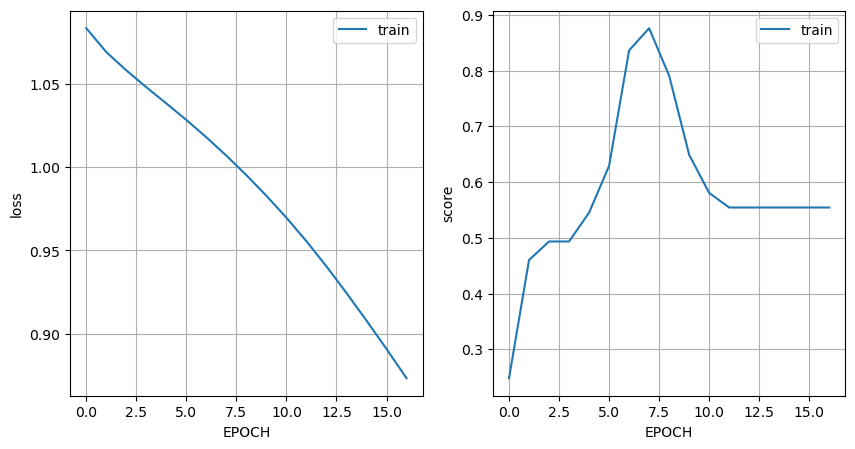

In [26]:

pp=utils.LossScorePlot(LOSS_HISTORY[0],SCORE_HISTORY[0])
pp.LSplot()


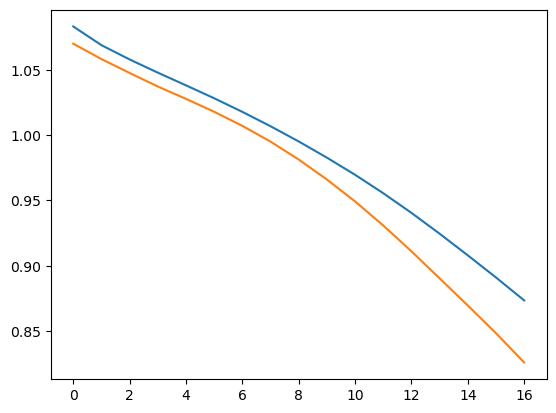

In [18]:
plt.plot(LOSS_HISTORY[0])
plt.plot(LOSS_HISTORY[1])